###Installing dependencies

In [1]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.1 MB/s eta 0:00:00


###Importing the required libraries

In [2]:
from keras.utils import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
from keras.optimizers import Adam
import tensorflow
from numpy.random import seed
tensorflow.random.set_seed(2)
seed(1)
import pandas as pd
import numpy as np
import string, os
import re 
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
from datasets import load_dataset

###Loading the fanfiction dataset

In [3]:
dataset =  load_dataset('jeremyf/fanfiction_z')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/jeremyf___json/jeremyf--fanfiction_z-ee1a1447c757b7ff/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

###Extracting the required stories for processing

In [4]:
story_list = [[i] for i in list(dataset['train']['story'])]
story_list = story_list[:25]

### Data pre-processing

In [5]:
cleaned_stories = []
for story in story_list:
  story = " ".join(story[0].split("\n\n"))
  story = story.lower()
  story = story.translate(str.maketrans('', '', string.punctuation))
  story = story.replace("\nend file\n",'')
  cleaned_stories.append(story)

print(cleaned_stories[0])

just a question what i thought when i first read this was that b was a guy who else thought that plz leave in the reviews and thanks so much for the people of fanfiction for adding this in love this book series and ill start doing actual fanfics on this now 


### Tokenization of the training data set

In [6]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(cleaned_stories):
    ## tokenization
    tokenizer.fit_on_texts(cleaned_stories)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in cleaned_stories:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(cleaned_stories)
print(inp_sequences[:10])

[[45, 5], [45, 5, 508], [45, 5, 508, 33], [45, 5, 508, 33, 7], [45, 5, 508, 33, 7, 122], [45, 5, 508, 33, 7, 122, 50], [45, 5, 508, 33, 7, 122, 50, 7], [45, 5, 508, 33, 7, 122, 50, 7, 84], [45, 5, 508, 33, 7, 122, 50, 7, 84, 449], [45, 5, 508, 33, 7, 122, 50, 7, 84, 449, 25]]


### Padding of the sequences for further processing

In [7]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

### Creating the LSTM model

In [ ]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    opt = Adam(learning_rate=0.001) 
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 7879, 10)          39520     
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 3952)              399152    
                                                                 
Total params: 483,072
Trainable params: 483,072
Non-trainable params: 0
_________________________________________________________________


###Fitting the model on training data

In [ ]:
history = model.fit(predictors, label, validation_split=0.10, epochs=50, verbose=True)

Epoch 1/50
761/761 [==============================] - 181s 229ms/step - loss: 6.7268 - accuracy: 0.0476 - val_loss: 6.7720 - val_accuracy: 0.0677
Epoch 2/50
761/761 [==============================] - 174s 228ms/step - loss: 6.3876 - accuracy: 0.0509 - val_loss: 6.8787 - val_accuracy: 0.0654
Epoch 3/50
761/761 [==============================] - 174s 228ms/step - loss: 6.2689 - accuracy: 0.0558 - val_loss: 6.9598 - val_accuracy: 0.0688
Epoch 4/50
761/761 [==============================] - 174s 228ms/step - loss: 6.1356 - accuracy: 0.0615 - val_loss: 6.9814 - val_accuracy: 0.0691
Epoch 5/50
761/761 [==============================] - 174s 228ms/step - loss: 6.0049 - accuracy: 0.0654 - val_loss: 7.0377 - val_accuracy: 0.0680
Epoch 6/50
761/761 [==============================] - 174s 228ms/step - loss: 5.8735 - accuracy: 0.0692 - val_loss: 7.0841 - val_accuracy: 0.0725
Epoch 7/50
761/761 [==============================] - 174s 228ms/step - loss: 5.7383 - accuracy: 0.0741 - val_loss: 7.1672 -

###Plotting the accuracy and loss graphs of the model

In [ ]:
import matplotlib.pyplot as plt

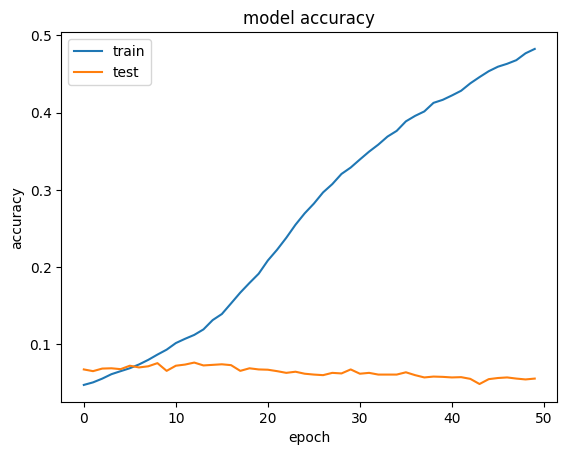

<Figure size 640x480 with 0 Axes>

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('accuracy.png', bbox_inches='tight')

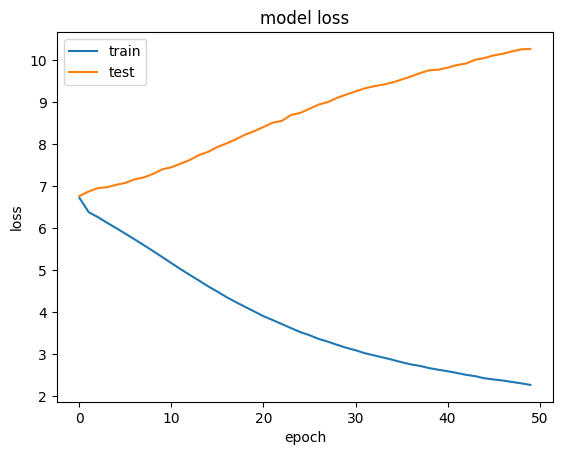

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('loss .png', bbox_inches='tight')

### Save the model

In [ ]:
model.save('lstm_working_new.h5')

###Loading the saved model

In [18]:
new_model = tensorflow.keras.models.load_model('lstm_working_new.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 7879, 10)          39520     
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 3952)              399152    
                                                                 
Total params: 483,072
Trainable params: 483,072
Non-trainable params: 0
_________________________________________________________________


### Generating stories using the trained model

In [8]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0),axis=1)
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

### A few prompts for story generation

In [10]:
print (generate_text("Just a question", 50, new_model, max_sequence_len))

Just A Question 2 Aybasbtu Game Script Zero Wing 2 One I Am Not Making My Characters My Doom I Cant Take It Let That Holy Endurance 510 Hound The Early Signs Of This Type Are Lip Splits Rotting Nose Enlarge Eyes Elongated Fingers And Nails Body Becomes Thinnertaller Hair Falls Out Smell


In [11]:
print (generate_text("United States", 50, new_model, max_sequence_len)) 

United States Is Tea Of The Early Signs Of The Experiment Pray The Experiment Is The Experiment That Still Watched The Single Friend Summer Is A Massive Edifice Proclaiming The Triumph Of Humans Reaching Beyond The Bounds Of Earth Suddenly Of The Ship Of The Crew Valiant Noble And A Single Friend


In [12]:
print (generate_text("Alice in wonderland", 50, new_model, max_sequence_len)) 

Alice In Wonderland Your Remains Rating Zero Wing 2 One I Can Explain Gifts Not A Scientific Man I 1 You Gentlemen Up It Are Like A Lot Oneshot Disclaimer I Need To Be School With My House And Taking Ill The Group Of Justice A Small Metal Guys Had Opened That He


###perplexity calculation

In [24]:
evaluate_stories = dataset['train']['story'][26:28]
print(len(evaluate_stories))

2


In [25]:
cleaned_stories_eval = []
for story in evaluate_stories:
  story = " ".join(story.split("\n\n"))
  story = story.lower()
  story = story.translate(str.maketrans('', '', string.punctuation))
  story = story.replace("\nend file\n",'')
  cleaned_stories_eval.append(story)

print(cleaned_stories_eval[0])

the vita nova incident i climbed up a large rock with a hunting rifle slung across my back it was early in the morning and i was searching for an elk i was a hunter and the elk often roamed on my ranch i looked through my binoculars but all i saw were vultures picking at a rotting elk corps this was the third one this week i couldnt figure out what was happening to my elk a little bummed out i headed back home trying to figure out what was going on i lived in a single story log cabin my grandpa and i had built together it was a sturdy cabin and i kept it in good repair my grandpa passed away a couple of years ago and i now live in the cabin alone well almost i was greeted at the door by the frantic barking and shuffling of rika my four year old tan and black german shepherd immediately after i opened the door rika jumped on me and started to lick my arms i know you wanna go huntin but youre just no good at it i said as i rubbed her ears rika cocked her head and whimpered how bout some 

In [26]:
inp_sequences_eval, total_words_eval = get_sequence_of_tokens(cleaned_stories_eval)
print(inp_sequences_eval[:10])

[[1, 1149], [1, 1149, 1150], [1, 1149, 1150, 1063], [1, 1149, 1150, 1063, 4], [1, 1149, 1150, 1063, 4, 1862], [1, 1149, 1150, 1063, 4, 1862, 28], [1, 1149, 1150, 1063, 4, 1862, 28, 5], [1, 1149, 1150, 1063, 4, 1862, 28, 5, 705], [1, 1149, 1150, 1063, 4, 1862, 28, 5, 705, 824], [1, 1149, 1150, 1063, 4, 1862, 28, 5, 705, 824, 20]]


In [27]:
predictors_eval, label_eval, max_sequence_len_eval = generate_padded_sequences(inp_sequences_eval)

In [29]:
test_loss, test_accuracy = new_model.evaluate(predictors, label)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


846/846 [==============================] - 92s 104ms/step - loss: 2.7703 - accuracy: 0.5181
Test loss: 2.770331382751465
Test accuracy: 0.5180624723434448


In [30]:
print(tensorflow.math.exp(test_loss))

tf.Tensor(15.963923, shape=(), dtype=float32)
